<div class="alert alert-success" role="alert">


### Until July 18: Course Evaluation

We invite you to take part in the evaluation of this course. 
Visit the [**link**](https://evaluation.tu-darmstadt.de/evasys/online.php?pswd=6FTSJ) to access the evaluation form.

**If you enjoy the course**:<br> Let us know what’s working well. Your positive feedback helps us understand which aspects are effective and should be retained in future courses.

**If you have suggestions or criticism**:<br> This is your chance to highlight areas for improvement. Constructive feedback helps us tailor the course to better meet your needs.  

- *Speak to Us Directly*:<br>
If you are unsatisfied with any aspect of the course, we encourage you to speak to us directly. We can address your concerns faster than the central processing of the evaluation results. Your input matters, and we’re here to help you.  

# Exercise: (Py)Calphad

After working with atomistic simulations, we now shift our focus to a thermodynamic approach. While atomistic methods provide detailed insights into atomic interactions and short-range phenomena, they often fall short in efficiently predicting long-range phase stability and equilibria in complex, multicomponent systems. To address these challenges, we now move to the **CALPHAD** method.

CALPHAD, which stands for *CALculation of PHAse Diagrams*, is a computational methodology used to model and predict phase equilibria and thermodynamic properties of multicomponent materials systems. *It combines experimental data, thermodynamic principles, and mathematical models to construct databases that describe how materials behave under varying conditions of temperature, pressure, and composition*.

Originally developed to aid in alloy design and metallurgy, CALPHAD has since expanded into ceramics, polymers, and other complex materials. By providing accurate phase diagrams and property predictions, CALPHAD supports materials research, engineering, and development by reducing the need for extensive experimental trials. Its models are widely used in both academic research and industrial applications such as process optimization and new material design.

Before addressing the main tasks, let’s go through a quick tutorial to get familiar with the basic features of the CALPHAD approach.

<div style="background-color:#e6f0ff; padding: 10px; border-left: 5px solid #3399ff; font-family: sans-serif;">
  <p>
    We gratefully acknowledge the developers of 
    <a href="https://github.com/pycalphad/pycalphad" target="_blank" style="color:#0056b3; text-decoration:none;">
      PyCalphad
    </a>. 
  </p>
</div>

In [2]:
#! pip install pycalphad

from pycalphad import Database, calculate, equilibrium, variables as v, Model, binplot

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_context("talk")

import numpy as np

In [3]:
# EXECUTE THIS CELL
# Some utility functions

def print_constituents(phase_name, db):
    constituents = db.phases[phase_name].constituents
    print(f"Constituents for phase '{phase_name}':")
    for i, sublattice in enumerate(constituents):
        species_names = [sp.name for sp in sublattice]
        print(f"\tSublattice {i+1}: {', '.join(species_names)}")


def summarize_equilibrium_result(eq):
    """
    Print a complete summary of a PyCalphad equilibrium() result.
    Handles single-condition grids and prints:
      - Conditions
      - Total Gibbs energy
      - Phases
      - Phase amounts
      - Compositions (X)
      - Chemical potentials (MU)
      - Site fractions (Y)
    """
    print("Equilibrium Summary")
    print("-" * 60)

    # Identify scalar condition axes (e.g., T, P, X_NI)
    cond_axes = [ax for ax in eq.sizes if ax not in ['vertex', 'component', 'internal_dof']]
    coords = {name: eq.coords[name].values.item() for name in cond_axes}
    for k, v_ in coords.items():
        print(f"{k}:\t\t\t{v_}")

    # Total molar Gibbs energy
    GM = eq.GM.values.item()
    print(f"\nTotal molar Gibbs energy:\t{GM:.3f} J/mol\n")

    # Phase-level info
    phases = eq.Phase.values
    phase_amounts = eq.NP.values
    X = eq.X.values
    Y = eq.Y.values
    MU = eq.MU.values
    components = list(eq.component.values)
    n_vertices = eq.sizes['vertex']
    n_internal_dof = eq.sizes['internal_dof']

    # Print chemical potentials
    print("Chemical potentials (μ) [J/mol]:")
    for i, comp in enumerate(components):
        print(f"  μ({comp}):\t\t{MU[0, 0, 0, 0, i]:.3f}")
    print()

    # Print info per vertex (stable phases)
    for i in range(n_vertices):
        phase = phases[0, 0, 0, 0, i]
        if isinstance(phase, str) and phase != '':
            print(f"Phase: {phase}")
            print(f"  Amount: {phase_amounts[0, 0, 0, 0, i]:.4f} mol")
            print("  Composition (X):")
            for j, comp in enumerate(components):
                x_val = X[0, 0, 0, 0, i, j]
                print(f"    X({comp}): {x_val:.4f}")
            print()

    print("-" * 60)

## Opening and Exploring a Database

Before performing any calculation in PyCalphad, you need to define four key things:

1. A thermodynamic database

2. The chemical components (including `'VA'` for vacancies)

3. The phases to include in the calculation

4. The calculation conditions (e.g., temperature, composition)

To load a database, use the `Database()` command:

In [4]:
db = Database('Cr-Fe-Ni.tdb')

> **Note:** The `.tdb` file must be located in the same directory as your Jupyter notebook for this to work.

## Exploring Database Contents

Thermodynamic databases contain a lot of useful information to help you set up your calculation. Three particularly helpful things to examine are:

- The elements defined in the database

- The available phases

- The constituents of a specific phase

You can inspect them using the following commands:

In [5]:
print("The elements in this database are:")
print(db.elements)
print()
print("The phases in this database are:")
print(list(db.phases.keys()))
print()

The elements in this database are:
{'/-', 'VA', 'CR', 'NI', 'FE'}

The phases in this database are:
['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3', 'SIGMA']



In [6]:
for phase in list(db.phases.keys()):
    print_constituents(phase, db)
    print()

Constituents for phase 'LIQUID':
	Sublattice 1: FE, NI, CR

Constituents for phase 'BCC_A2':
	Sublattice 1: FE, NI, CR
	Sublattice 2: VA

Constituents for phase 'FCC_A1':
	Sublattice 1: FE, NI, CR
	Sublattice 2: VA

Constituents for phase 'HCP_A3':
	Sublattice 1: FE, NI, CR
	Sublattice 2: VA

Constituents for phase 'SIGMA':
	Sublattice 1: FE, NI
	Sublattice 2: CR
	Sublattice 3: FE, NI, CR



## Setting Conditions and Running Equilibrium Calculations

In thermodynamic calculations, you must specify $c + 2$ conditions for $c$ components. However, in PyCalphad, calculations are performed per mole of system (i.e., $n = 1$ is assumed by default), so you only need to define $c + 1$ conditions.

Each condition—pressure, temperature, and composition—is defined using variables from `pycalphad.variables`, usually accessed with the `v.` prefix:

- **Pressure**: `v.P`, in Pascals (Pa). Most databases assume a standard pressure of $101325$ Pa ($1$ atm), and often do not include explicit pressure dependence.

- **Temperature**: `v.T`, in Kelvin (K). Databases are generally valid between $\approx 298.15$ K and $6000$ K.

- **Composition**: `v.X('NI')`, which sets the mole fraction of a component (e.g., `'NI'` for nickel).

These variables are typically used with the `equilibrium()` function, which computes stable phase equilibria under given conditions.

The table below shows the variable names used to access results returned by `equilibrium()`, which are also property keywords you can use later on with the function `calculate()`:

| Property                      | Keyword                    |
|------------------------------|----------------------------|
| Molar Enthalpy               | `'HM'`                     |
| Mixing Enthalpy              | `'HM_MIX'`                 |
| Molar Gibbs Energy           | `'GM'`                     |
| Mixing Gibbs Energy          | `'GM_MIX'`                 |
| Molar Entropy                | `'SM'`                     |
| Heat Capacity (total)        | `'heat_capacity'`          |
| Degree of Ordering           | `'degree_of_ordering'` or `'DOO'` |
| Molar Heat Capacity          | `'CPM'`                    |
| Mixing Heat Capacity         | `'CPM_MIX'`                |
| Excess Mixing Energy         | `'excess_mixing_energy'`   |

Use these keywords to specify which thermodynamic quantity you would like to calculate.

When you load a thermodynamic database (like `Cr-Fe-Ni.tdb`), it contains models and data for many elements and phases, but you're free to focus on a subset (e.g., Cr) for your calculations or plotting.
You can restrict the component list manually:
```python
components = ['CR', 'VA']  # Always include 'VA' for vacancies
```
This tells PyCalphad that you want to perform calculations for the Cr unary system (i.e., pure chromium). The 'VA' component (vacancy) must always be included when working with substitutional phases in CALPHAD models, even if you're working with just one real element.

# Task (a): The Fe-Ni system

In this exercise, you will use PyCalphad to calculate the equilibrium phase assemblage of the Fe–Ni binary system under specified conditions.


1. Load the Thermodynamic Database
   Replace `'...'` with the actual filename that contains the thermodynamic data for the Fe–Ni system.

2. Define the Components

   * Use uppercase for chemical symbols (e.g., `'FE'`, `'NI'`)
   * Always include `'VA'` (the vacancy species), which is required for substitutional solution models.

3. Set the Calculation Conditions

   * Pressure: `101325` Pa (equivalent to 1 atm)
   * Temperature: `500` K
   * Composition: Mole fraction of Ni = `0.5` (i.e., a 50–50 Fe–Ni alloy)

4. Run the Calculation
   After executing the code, the `summarize_equilibrium_result(eq)` function (already defined in the notebook) will output a summary of the equilibrium:

   * Which phases are stable under the given conditions?
   * How much of each phase is present?
   * What is the composition of each phase (in terms of Fe and Ni)?

In [7]:
# COMPLETE AND EXECUTE THIS CELL
db = Database('Cr-Fe-Ni.tdb')

# Define the components:
# Capitalization matters! Use all caps (convention in CALPHAD).
# Always include 'VA' (vacancy) as a component.
# Always include your textual entries in single quotes.
components = ['FE', 'NI', 'VA']

# Define the phases to consider:
phases = list(db.phases.keys())

# Define calculation conditions as a dictionary:
# Keys are variables from pycalphad.variables (accessed via 'v.')
conditions = {
    v.P: 101325,             # Pressure in Pascals 
    v.T: 500,                # Temperature in Kelvin
    v.X('NI'): 0.5           # Mole fraction of Ni (Fe is implied)
}

# Run the equilibrium calculation
eq = equilibrium(db, components, phases, conditions)

summarize_equilibrium_result(eq)

Equilibrium Summary
------------------------------------------------------------
N:			1.0
P:			101325.0
T:			500.0
X_NI:			0.5

Total molar Gibbs energy:	-20768.852 J/mol

Chemical potentials (μ) [J/mol]:
  μ(FE):		-15187.728
  μ(NI):		-26349.976

Phase: BCC_A2
  Amount: 0.1101 mol
  Composition (X):
    X(FE): 0.9853
    X(NI): 0.0147

Phase: FCC_A1
  Amount: 0.8899 mol
  Composition (X):
    X(FE): 0.4399
    X(NI): 0.5601

------------------------------------------------------------


# Task (b): The Fe-Ni phase diagram

In this exercise, you will generate a binary phase diagram for the Fe–Ni system at constant pressure (1 atm) using PyCalphad’s built-in `binplot()` function.

The `binplot()` function performs equilibrium calculations over a grid of temperature and composition values, identifies phase boundaries, and produces a clean binary phase diagram with labeled phase regions.

You have already defined the database, components, and conditions in the previous equilibrium exercise. Now, you will use this setup to visualize how phase stability changes with temperature and composition.

Unlike a single-point equilibrium calculation, `binplot()` requires the `conditions` dictionary to specify ranges using the format:

```python
(start, stop, step)
```

Update the code to reflect the following:

* Pressure: constant at `101325` Pa (1 atm)

* Temperature: from `400` K to `2000` K, in steps of `50` K

* Ni mole fraction: from `0` to `0.6`, in steps of `0.01` (Fe is the remainder in this binary system)

Once complete, running the cell will display the binary phase diagram, showing which phases are stable under different combinations of temperature and composition.

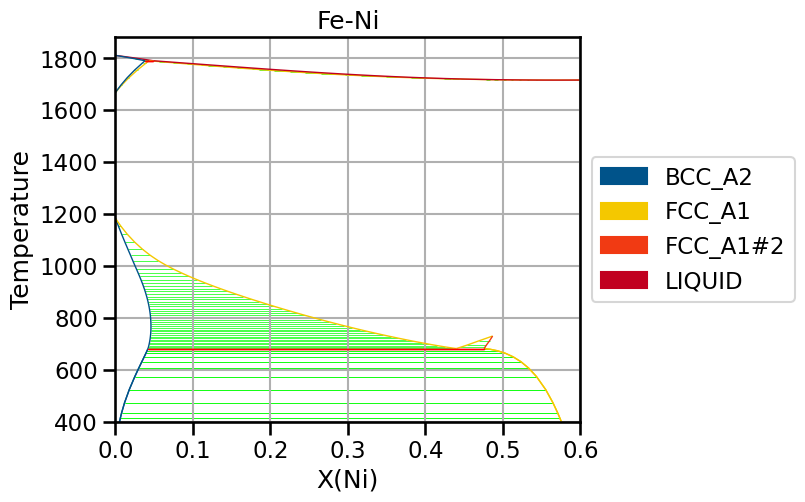

In [8]:
phases = list(db.phases.keys())

fig = binplot(
    db,
    components,
    phases,
    conditions = {
    v.P: 101325    ,              # Pressure in Pascals 
    v.T: (400, 2000, 50)    ,            # Temperature in Kelvin
    v.X('NI'): (0, 0.6, 0.01)        # Mole fraction of Ni
    }
).get_figure()

plt.grid()
# Set the size of the figure
fig.set_size_inches(6, 5)

<div class="alert alert-info" role="alert">


In our phase diagram, `FCC_A1#2` represents a second composition of the FCC phase that is stable at the same time as another FCC phase (`FCC_A1`).

This happens in regions where the system splits into two FCC phases with different chemical compositions, usually during a miscibility gap or three-phase equilibrium.

Even though both are structurally the same (FCC), Thermo-Calc gives them different labels (`#2`, `#3`, etc.) to show they are chemically distinct and coexist in equilibrium.

So, the `#2` does not mean a new phase, it just marks a second stable composition of FCC at the same temperature.

# Task (c): Verify Phase Stability with `equilibrium()`

Use individual `equilibrium()` calculations to verify the stable phases at specific points on the Fe–Ni phase diagram.

For each point, run a separate `equilibrium()` call and examine:

* Which phases are stable

* The phase fractions (amounts)

* The composition of each phase (in terms of Fe and Ni)

Then, compare the output to the corresponding region of the phase diagram generated earlier. 


Points to Investigate:
| X(Ni) | T (K) |
|-------|-------|
| 0.00  |  800  |
| 0.00  | 1700  |
| 0.10  |  600  |
| 0.10  |  800  |
| 0.47  |  700  |
| 0.47  | 1200  |
| 0.47  | 1800  |

<div class="alert alert-info" role="alert">

### Summary

In [9]:
# Load the thermodynamic database
db = Database('Cr-Fe-Ni.tdb')

# Define components and phases
components = ['NI', 'FE', 'VA']
phases = list(db.phases.keys())

# Define the pressure (constant)
pressure = 101325  # 1 atm in Pascals

# Define (X(Ni), T(K)) pairs
condition_list = [
    (0.00, 800),
    (0.00, 1700),
    (0.10, 600),
    (0.10, 800),
    (0.47, 700),
    (0.47, 1200),
    (0.47, 1800),
]

# Loop through each condition and calculate equilibrium
for x_ni, temp in condition_list:
    print(f"\n--- Equilibrium Summary for X(Ni) = {x_ni}, T = {temp} K ---")

    conditions = {
        v.P: pressure,
        v.T: temp,
        v.X('NI'): x_ni
    }

    # Perform equilibrium calculation
    eq = equilibrium(db, components, phases, conditions)

    # Summarize result
    summarize_equilibrium_result(eq)



--- Equilibrium Summary for X(Ni) = 0.0, T = 800 K ---
Equilibrium Summary
------------------------------------------------------------
N:			1.0
P:			101325.0
T:			800.0
X_NI:			1e-10

Total molar Gibbs energy:	-29906.586 J/mol

Chemical potentials (μ) [J/mol]:
  μ(FE):		-29906.586
  μ(NI):		-179047.385

Phase: BCC_A2
  Amount: 1.0000 mol
  Composition (X):
    X(FE): 1.0000
    X(NI): 0.0000

------------------------------------------------------------

--- Equilibrium Summary for X(Ni) = 0.0, T = 1700 K ---
Equilibrium Summary
------------------------------------------------------------
N:			1.0
P:			101325.0
T:			1700.0
X_NI:			1e-10

Total molar Gibbs energy:	-98135.816 J/mol

Chemical potentials (μ) [J/mol]:
  μ(FE):		-98135.816
  μ(NI):		-425506.028

Phase: BCC_A2
  Amount: 1.0000 mol
  Composition (X):
    X(FE): 1.0000
    X(NI): 0.0000

------------------------------------------------------------

--- Equilibrium Summary for X(Ni) = 0.1, T = 600 K ---
Equilibrium Summary
----

<div class="alert alert-info" role="alert">

### Annotated phase diagram

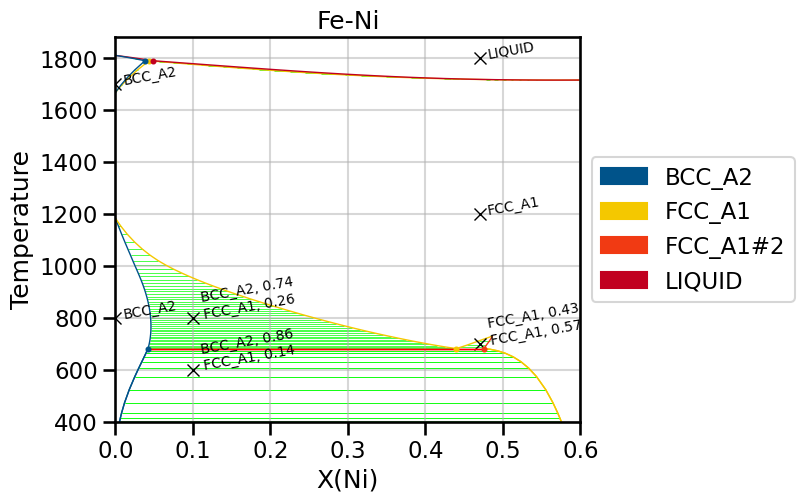

In [10]:
phases = list(db.phases.keys())

fig = binplot(
    db,
    components,
    phases,
    conditions = {
    v.P: 101325 ,              # Pressure in Pascals 
    v.T: (400,2000,50) ,            # Temperature in Kelvin
    v.X('NI'): (0,0.6,0.01)        # Mole fraction of Ni
    },
    plot_kwargs={'label_nodes': True}
).get_figure()

plt.grid(alpha=0.5)
# Set the size of the figure
fig.set_size_inches(5, 5)

# Define (X, T) pairs
points = [
    (0.00, 800),
    (0.00, 1700),
    (0.10, 600),
    (0.10, 800),
    (0.47, 700),
    (0.47, 1200),
    (0.47, 1800),
]

# Corresponding annotations (Phase, Amount)
annotations = [
    "BCC_A2",
    "BCC_A2",
    "BCC_A2, 0.86\nFCC_A1, 0.14",
    "BCC_A2, 0.74\nFCC_A1, 0.26",
    "FCC_A1, 0.43\nFCC_A1, 0.57",
    "FCC_A1",
    "LIQUID"
]

for (x, t), label in zip(points, annotations):
    plt.plot(x, t, 'x', color='black')
    plt.annotate(label, (x, t), textcoords="offset points", xytext=(5, 0), ha='left', fontsize=10, rotation=10)

fig.set_size_inches(6, 5)
plt.show()

## Task (d): Calculating Thermodynamic Properties

In this task, you will explore how key thermodynamic properties evolve with temperature for the Fe–Ni binary system at a fixed composition.

Using `equilibrium()` over a temperature range, you will calculate and visualize:

* Molar enthalpy
* Total (equilibrium) heat capacity
* Phase fractions

Specify:

* Pressure: constant at `101325` Pa (1 atm)

* Temperature: from `400` K to `1800` K, in steps of `5` K

* Ni mole fraction: from `0.47` (Fe is the remainder in this binary system)

This analysis helps reveal how phase transitions affect thermodynamic behavior.

> To specify which properties to calculate, refer to the property name table provided in the tutorial. Be sure to use the correct keyword for each quantity. 

- Do you observe any phase transitions in the plots?

- If so, what order are the transitions?

- Based on the phase fractions and property trends, can you identify which phase transitions are occurring?

| Property                      | Keyword                    |
|------------------------------|----------------------------|
| Molar Enthalpy               | `'HM'`                     |
| Mixing Enthalpy              | `'HM_MIX'`                 |
| Molar Gibbs Energy           | `'GM'`                     |
| Mixing Gibbs Energy          | `'GM_MIX'`                 |
| Molar Entropy                | `'SM'`                     |
| Heat Capacity (total)        | `'heat_capacity'`          |
| Degree of Ordering           | `'degree_of_ordering'` or `'DOO'` |
| Molar Heat Capacity          | `'CPM'`                    |
| Mixing Heat Capacity         | `'CPM_MIX'`                |
| Excess Mixing Energy         | `'excess_mixing_energy'`   |

<div class="alert alert-info" role="alert">

### Solution
As we analyze the thermodynamic behavior of a binary alloy (Ni = 0.47) across temperature, we observe two major phase transitions: a solid–solid transformation (BCC to FCC) and melting (FCC to liquid).

From the phase fraction plot, the BCC to FCC transition occurs around 700 K. This is a first-order phase transition, evident from a disconitinuity in the enthalpy curve (visible if you narrow the temperature scale) and the peak in heat capacity. Similarly, melting occurs near 1750–1800 K, where the FCC phase disappears and the liquid phase appears. This too is a first-order transition, as it involves latent heat.

> We see that the $C_p$ computed by CALPHAD (via `equilibrium(..., output=['heat_capacity'])`) has an unexpected behavior at melting: it shows a gap instead of a spike. 

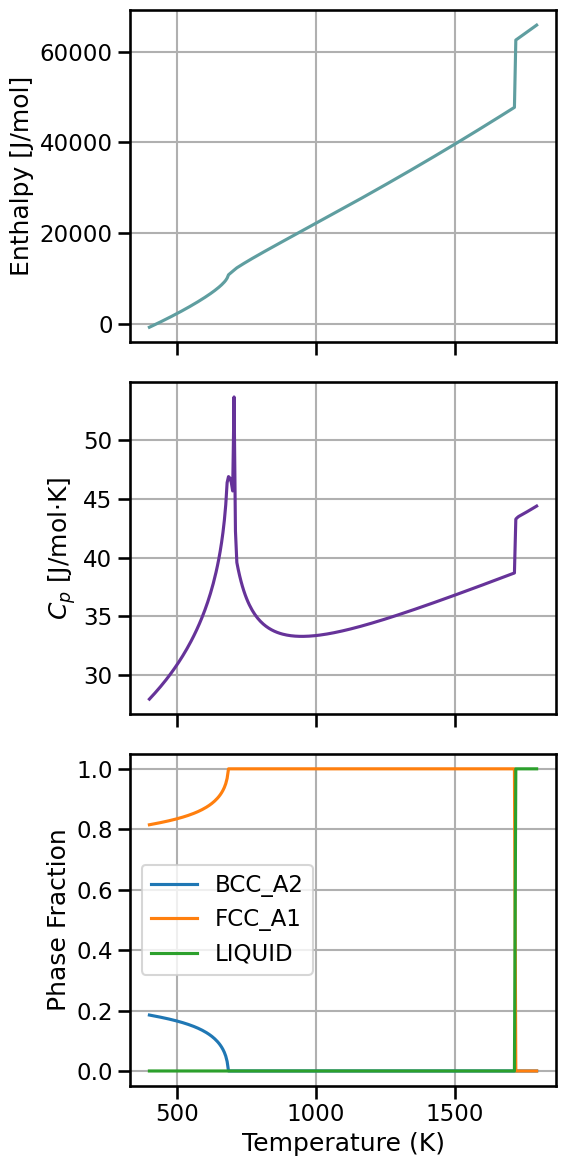

In [12]:
# === Define Conditions ===

conditions = {
    v.P: 101325    ,         # Pressure (1 atm)
    v.T: (400, 1800, 5)  , # Temperature sweep from 400 K to 1800 K, step = 5 K
    v.X('NI'): 0.47      # Fixed Ni composition
}

# === Run Equilibrium Calculations ===

# Heat capacity and phase data
eq_cp = equilibrium(db, components, phases, conditions, output=['heat_capacity'])

# Enthalpy data
eq_hm = equilibrium(db, components, phases, conditions, output=['HM'])

# === Extract Temperature ===
T = eq_cp['T'].values

# === Extract Enthalpy ===
Hm = np.squeeze(eq_hm['HM'].values)

# === Extract Heat Capacity ===
Cp = np.squeeze(eq_cp['heat_capacity'].values)

# === Extract Phase Fractions ===
phase_names = eq_cp['Phase'].values[0, 0, :, 0]  # shape: (T, vertex)
amounts = eq_cp['NP'].values[0, 0, :, 0]

# Organize phase fractions by phase
unique_phases = sorted(set(p for row in phase_names for p in row if p != ''))
phase_amounts = {phase: np.zeros_like(T) for phase in unique_phases}

for i, row in enumerate(phase_names):
    for j, phase in enumerate(row):
        if phase and not np.isnan(amounts[i, j]):
            phase_amounts[phase][i] += amounts[i, j]


# === Plotting ===

fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)

# Enthalpy
axs[0].plot(T, Hm, color='cadetblue')
axs[0].set_ylabel('Enthalpy [J/mol]')
axs[0].grid(True)

# Heat Capacity
axs[1].plot(T, Cp, color='rebeccapurple')
axs[1].set_ylabel(r'$C_p$ [J/mol·K]')
axs[1].grid(True)

# Phase Fractions
for phase, data in phase_amounts.items():
    axs[2].plot(T, data, label=phase)
axs[2].set_ylabel('Phase Fraction')
axs[2].set_xlabel('Temperature (K)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">


To fix this, *we compute $C_p$ numerically using the derivative of enthalpy*:

$$
C_p = \frac{dH}{dT}
$$

This method captures the latent heat as a sharp spike, correctly highlighting the melting transition.

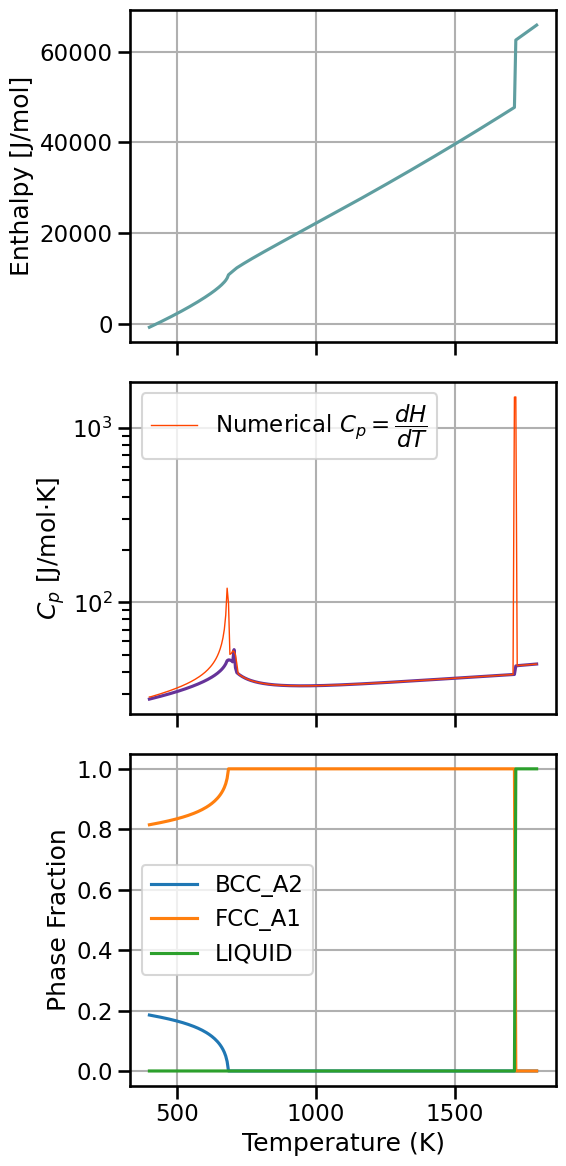

In [13]:
# === Define Conditions ===

conditions = {
    v.P: 101325    ,         # Pressure (1 atm)
    v.T: (400, 1800, 5)  , # Temperature sweep from 400 K to 1800 K, step = 5 K
    v.X('NI'): 0.47      # Fixed Ni composition
}

# === Run Equilibrium Calculations ===

# Heat capacity and phase data
eq_cp = equilibrium(db, components, phases, conditions, output=['heat_capacity'])

# Enthalpy data
eq_hm = equilibrium(db, components, phases, conditions, output=['HM'])

# === Extract Temperature ===
T = eq_cp['T'].values

# === Extract Enthalpy ===
Hm = np.squeeze(eq_hm['HM'].values)

# === Extract Heat Capacity ===
Cp = np.squeeze(eq_cp['heat_capacity'].values)
# Numerical Cp from enthalpy
Cp_numeric = np.gradient(Hm, T)


# === Extract Phase Fractions ===
phase_names = eq_cp['Phase'].values[0, 0, :, 0]  # shape: (T, vertex)
amounts = eq_cp['NP'].values[0, 0, :, 0]

# Organize phase fractions by phase
unique_phases = sorted(set(p for row in phase_names for p in row if p != ''))
phase_amounts = {phase: np.zeros_like(T) for phase in unique_phases}

for i, row in enumerate(phase_names):
    for j, phase in enumerate(row):
        if phase and not np.isnan(amounts[i, j]):
            phase_amounts[phase][i] += amounts[i, j]


# === Plotting ===

fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)

# Enthalpy
axs[0].plot(T, Hm, color='cadetblue')
axs[0].set_ylabel('Enthalpy [J/mol]')
axs[0].grid(True)

# Heat Capacity
axs[1].plot(T, Cp, color='rebeccapurple')
axs[1].plot(T, Cp_numeric, color='orangered', linewidth=1, label=r'Numerical $C_p = \dfrac{dH}{dT}$')
axs[1].set_ylabel(r'$C_p$ [J/mol·K]')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].grid(True)

# Phase Fractions
for phase, data in phase_amounts.items():
    axs[2].plot(T, data, label=phase)
axs[2].set_ylabel('Phase Fraction')
axs[2].set_xlabel('Temperature (K)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()